Text(0.5, 1.0, 'Original Image')

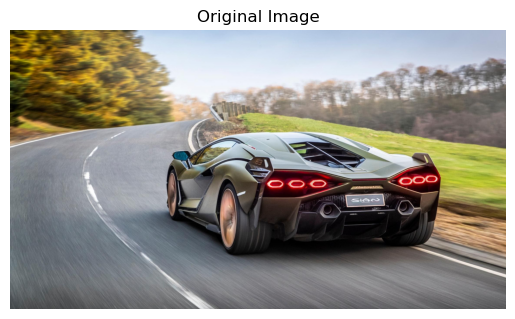

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображения
img = cv2.imread('Pic1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')


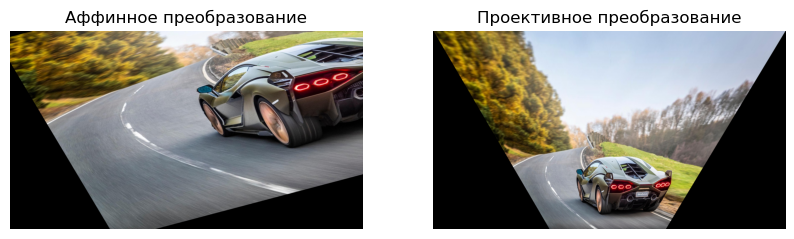

In [16]:
# Аффинное преобразование (масштабирование и поворот)
rows, cols, ch = img.shape
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])

M_affine = cv2.getAffineTransform(pts1, pts2)
affine_transformed = cv2.warpAffine(img, M_affine, (cols, rows))

# Проективное преобразование (перспективная трансформация)
pts1_proj = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
pts2_proj = np.float32([[0, 0], [cols-1, 0], [int(0.33*cols), rows-1], [int(0.66*cols), rows-1]])

M_projective = cv2.getPerspectiveTransform(pts1_proj, pts2_proj)
projective_transformed = cv2.warpPerspective(img, M_projective, (cols, rows))

# Визуализация результатов
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(affine_transformed)
plt.title('Аффинное преобразование')
plt.axis('off')
plt.subplot(122)
plt.imshow(projective_transformed)
plt.title('Проективное преобразование')
plt.axis('off')
plt.show()


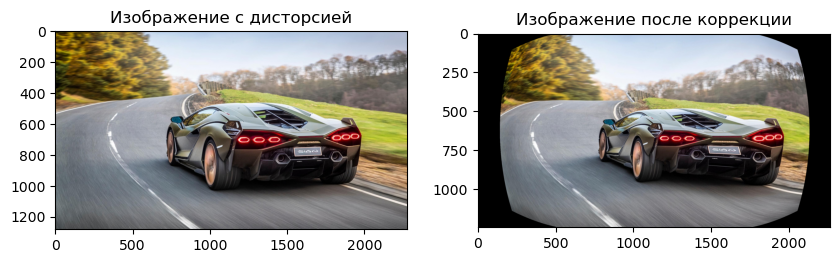

In [13]:
camera_matrix = np.array([[800, 0, img.shape[1]//2],
                          [0, 800, img.shape[0]//2],
                          [0, 0, 1]])

# Коэффициенты дисторсии [k1, k2, p1, p2, k3] (для примера можно задать такие значения)
dist_coeffs = np.array([-0.3, 0.1, 0.0, 0.0, 0.0])  # для бочкообразной дисторсии

# Коррекция дисторсии
h, w = img.shape[:2]
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
undistorted_img = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)

# Обрезка изображения до корректированного размера
x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]

# Визуализация исходного и корректированного изображений
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Изображение с дисторсией')

plt.subplot(1, 2, 2)
plt.imshow(undistorted_img)
plt.title('Изображение после коррекции')

plt.show()

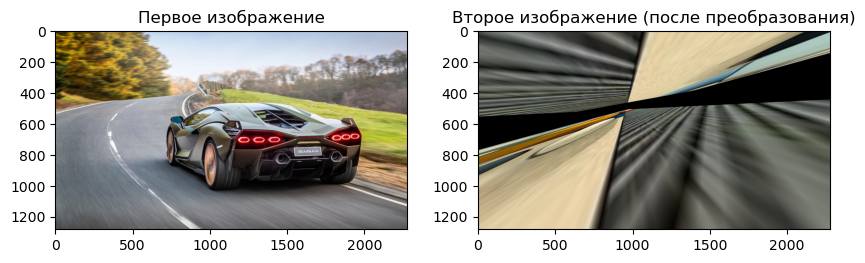

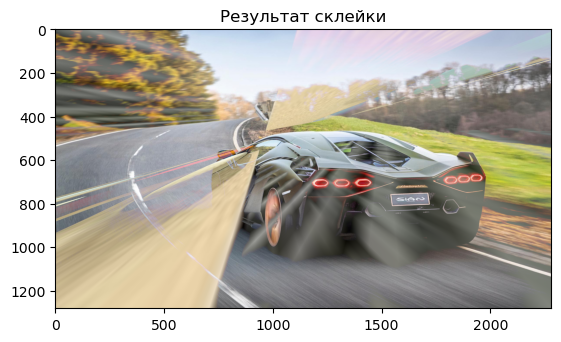

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка двух изображений
img1 = cv2.imread('Pic1.jpg')
img2 = cv2.imread('Pic2.jpg')

# Преобразование изображений в градации серого для поиска ключевых точек
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Использование детектора SIFT для поиска ключевых точек и дескрипторов
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Сопоставление ключевых точек с помощью FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Применение соотношения Лоу для фильтрации хороших матчей
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Найти ключевые точки в обоих изображениях
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Вычисление матрицы гомографии
H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# Преобразование второго изображения в систему координат первого
height, width, channels = img1.shape
warped_img2 = cv2.warpPerspective(img2, H, (width, height))

# "Склейка" изображений
result = np.maximum(img1, warped_img2)

# Визуализация результата
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Первое изображение')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_img2, cv2.COLOR_BGR2RGB))
plt.title('Второе изображение (после преобразования)')

plt.figure()
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Результат склейки')
plt.show()
